
# MTH 354 — Lab08: Classification with Transformers (due 11/20)

**Names:** Adriana Soldat  


# Assignment:


## 1. Analyze `08_CLASS_transformers.ipynb` results and  modifications
Make a copy and go through and run the `08_CLASS_transformers.ipynb` notebook.  Answer the following questions using that notebook.
Pick **one** of the following routes (in each section) and **justify** your choices with 3–5 sentences. Include **plots/tables** as appropriate.

1. **Model Tuning:** Change **one** of the following and report validation accuracy (and one more metric, such as confusion matrix or heatmap):
   - Regularization strength
   - Network depth/width (add/remove a layer or change units/filters)  
   - Learning rate or number of training epochs  

2. **Error Analysis:** From the confusion matrix, identify **two** most-confused class pairs.  
   - Show 2–4 example images from each pair.  
   - Hypothesize **why** they’re confused and propose **one** data or model change to separate them.

3. **Ablation Study:** Toggle **one** component of your pipeline (e.g., drop-out, batch-norm, augmentation on/off).  
   - Compare metrics before vs after (accuracy + 1 more of your choice).  
   - State whether the difference is **practically meaningful** and **statistically plausible** (one-sentence rationale is enough).

> **Deliverables:** markdown cells with your explanations, plus code cells that reproduce your experiments and any plots/tables.


# **1. Model Tuning: Learning Rate Comparison**
In this experiment, I changed the learning rate (alpha) while keeping all other hyperparameters unchanged.
I trained the Vision Transformer with three different learning rates:

α = 0.001

α = 0.005 (baseline)

α = 0.01
while decreasing ephos to 2 to make the training faster.
Learning rate strongly affects optimization:
A small LR makes training slower but stable, while a large LR may speed up convergence but can overshoot and reduce accuracy.

Below, I compare validation accuracy and confusion matrices.


In [82]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.optim import Adam
from torchvision.datasets.mnist import MNIST
from torch.utils.data import DataLoader
import numpy as np
import random


In [83]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


In [84]:
class PatchEmbedding(nn.Module):
  def __init__(self, d_model, img_size, patch_size, n_channels):
    super().__init__()

    self.d_model = d_model # Dimensionality of Model
    self.img_size = img_size # Image Size
    self.patch_size = patch_size # Patch Size
    self.n_channels = n_channels # Number of Channels

    self.linear_project = nn.Conv2d(self.n_channels, self.d_model, kernel_size=self.patch_size, stride=self.patch_size)

  # B: Batch Size
  # C: Image Channels
  # H: Image Height
  # W: Image Width
  # P_col: Patch Column
  # P_row: Patch Row
  def forward(self, x):
    x = self.linear_project(x) # (B, C, H, W) -> (B, d_model, P_col, P_row)
    x = x.flatten(2) # (B, d_model, P_col, P_row) -> (B, d_model, P)
    x = x.transpose(1, 2) # (B, d_model, P) -> (B, P, d_model)
    return x


In [85]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super().__init__()
        # Initialize the classification token as a learnable parameter
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        # Create a matrix to hold the positional encodings
        pe = torch.zeros(max_seq_length, d_model)
        # Fill the positional encoding matrix
        for pos in range(max_seq_length):
            for i in range(d_model):
                if i % 2 == 0:
                    # Use sine for even indices
                    pe[pos][i] = np.sin(pos / (10000 ** (i / d_model)))
                else:
                    # Use cosine for odd indices
                    pe[pos][i] = np.cos(pos / (10000 ** ((i - 1) / d_model)))

        # Register the positional encodings as a buffer (not a learnable parameter)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # Expand the classification token to match the batch size
        tokens_batch = self.cls_token.expand(x.size()[0], -1, -1)
        # Concatenate the classification token to the beginning of each input sequence
        x = torch.cat((tokens_batch, x), dim=1)
        # Add positional encodings to the input embeddings
        x = x + self.pe
        return x


In [86]:
class AttentionHead(nn.Module):
  def __init__(self, d_model, head_size):  # Initialize with model dimensionality and head size.
    super().__init__()  # Call the parent class's initializer.
    self.head_size = head_size  # Store the size of the attention head.

    self.query = nn.Linear(d_model, head_size)  # Linear layer to project input to queries.
    self.key = nn.Linear(d_model, head_size)    # Linear layer to project input to keys.
    self.value = nn.Linear(d_model, head_size)  # Linear layer to project input to values.


  def forward(self, x):
    # Obtaining Queries, Keys, and Values
    Q = self.query(x)
    K = self.key(x)
    V = self.value(x)

    attention = Q @ K.transpose(-2, -1)  # Calculate attention scores using the dot product of queries and keys.
    attention = attention / (self.head_size ** 0.5)  # Scale the attention scores to stabilize training.
    attention = torch.softmax(attention, dim=-1)  # Apply softmax to normalize the scores.
    attention = attention @ V  # Compute the final output by weighting values by the attention scores.

    return attention

In [87]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        # Determine the size of each attention head.
        self.head_size = d_model // n_heads
        # Linear layer to project the concatenated output back to the original dimension.
        self.W_o = nn.Linear(d_model, d_model)
        # Create multiple attention heads by instantiating the AttentionHead class n_heads times.
        self.heads = nn.ModuleList([AttentionHead(d_model, self.head_size) for _ in range(n_heads)])

    def forward(self, x):
        # Apply each attention head to the input x and concatenate their outputs along the last dimension.
        out = torch.cat([head(x) for head in self.heads], dim=-1)
        # Apply the linear projection to the concatenated output.
        out = self.W_o(out)

        return out


In [88]:
class TransformerEncoder(nn.Module):
    def __init__(self, d_model, n_heads, r_mlp=4):
        super().__init__()
        self.d_model = d_model  # Store the model dimensionality (size of each patch embedding)
        self.n_heads = n_heads  # Store the number of attention heads

        # Layer normalization before Multi-Head Attention
        # Normalizes inputs to stabilize training and help the attention mechanism work effectively
        self.ln1 = nn.LayerNorm(d_model)

        # Multi-Head Self-Attention layer
        # Allows each patch to attend to all other patches in the sequence
        # Multiple heads capture different types of relationships (e.g., edges, textures, long-range dependencies)
        self.mha = MultiHeadAttention(d_model, n_heads)

        # Layer normalization before Feedforward network
        # Stabilizes input to the MLP and helps gradient flow
        self.ln2 = nn.LayerNorm(d_model)

        # Feedforward network (MLP) for patch-wise nonlinear transformation
        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_model * r_mlp),  # Expands dimensionality to allow richer feature transformations
            nn.GELU(),  # Non-linear activation function to enable learning complex patterns
            nn.Linear(d_model * r_mlp, d_model)  # Projects back to original dimension for residual addition
        )

    def forward(self, x):
        # Residual Connection After Sub-Layer 1 (MHA)
        # Combines original input with context-aware features from attention
        out = x + self.mha(self.ln1(x))

        # Residual Connection After Sub-Layer 2 (MLP)
        # Combines input to the MLP with the transformed features, preserving original information while adding higher-level features
        out = out + self.mlp(self.ln2(out))

        return out


In [89]:
class VisionTransformer(nn.Module):
    def __init__(self, d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers):
        super().__init__()
        # Ensure the image dimensions are divisible by the patch size.
        assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0, "img_size dimensions must be divisible by patch_size dimensions"
        # Ensure the model dimensionality is divisible by the number of attention heads.
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

        self.d_model = d_model  # the dimensionality of the model.
        self.n_classes = n_classes  # the number of output classes.
        self.img_size = img_size  # the image size.
        self.patch_size = patch_size  # the patch size.
        self.n_channels = n_channels  # the number of channels (e.g., 1 for grayscale, 3 for RGB).
        self.n_heads = n_heads  # the number of attention heads.

        # Calculate the number of patches and maximum sequence length (including the class token).
        self.n_patches = (self.img_size[0] * self.img_size[1]) // (self.patch_size[0] * self.patch_size[1])
        self.max_seq_length = self.n_patches + 1  # +1 for the class token.

        # Initialize the patch embedding layer.
        self.patch_embedding = PatchEmbedding(self.d_model, self.img_size, self.patch_size, self.n_channels)
        # Initialize the positional encoding layer.
        self.positional_encoding = PositionalEncoding(self.d_model, self.max_seq_length)
        # Initialize the Transformer encoder layers.
        self.transformer_encoder = nn.Sequential(*[TransformerEncoder(self.d_model, self.n_heads) for _ in range(n_layers)])

        # Classification MLP: Project the class token to the output class probabilities.
        self.classifier = nn.Sequential(
            nn.Linear(self.d_model, self.n_classes),  # Linear layer to project to the number of classes.
            nn.Softmax(dim=-1)  # Apply softmax to get class probabilities.
        )

    def forward(self, images):
        x = self.patch_embedding(images)  # Convert images into patch embeddings.
        x = self.positional_encoding(x)  # Add positional encodings to the patch embeddings.
        x = self.transformer_encoder(x)  # Pass through the Transformer encoder layers.
        x = self.classifier(x[:,0])  # Use the class token for classification.

        return x


In [90]:
d_model = 9  # Dimensionality of each patch embedding; controls the size of feature vectors for each patch.
n_classes = 10  # Number of output classes for classification (e.g., 0–9 for digits in MNIST).
img_size = (32,32)  # Input image size (height, width) that the model will process.
patch_size = (16,16)  # Size of each patch extracted from the image (height, width); determines sequence length.
n_channels = 1  # Number of channels in input images (1 for grayscale, 3 for RGB).
n_heads = 3  # Number of attention heads in multi-head self-attention; allows the model to attend to multiple relationships simultaneously.
n_layers = 3  # Number of Transformer encoder layers stacked in the model; deeper layers can learn more complex patterns.
batch_size = 128  # Number of images processed in a single forward/backward pass; affects memory usage and training stability.
epochs = 2  # Number of full passes through the entire training dataset; controls how long the model trains.
alpha = [0.001, 0.005, 0.01]  # Learning rate for the optimizer; determines the step size during gradient descent updates.
results = {}


In [91]:
# Define a series of image transformations
transform = T.Compose([
    T.Resize(img_size),  # Resize the images to the specified img_size.
    T.ToTensor()  # Convert the images to PyTorch tensors.
])

# Load the MNIST training dataset with the specified transformations.
train_set = MNIST(
    root="./../datasets", train=True, download=True, transform=transform
)

# Load the MNIST test dataset with the specified transformations.
test_set = MNIST(
    root="./../datasets", train=False, download=True, transform=transform
)

# Create a DataLoader for the training set, shuffling the data and setting the batch size.
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
# Create a DataLoader for the test set, without shuffling, and setting the batch size.
test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size)


In [92]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Determine the device to use for training (GPU if available, otherwise CPU).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Print the device being used, and if CUDA is available, also print the name of the GPU.
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

for lr in alpha:
    print(f"Training with learning rate = {lr}")
# Instantiate the Vision Transformer model and move it to the selected device.
    transformer = VisionTransformer(d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers).to(device)

# Initialize the Adam optimizer with the model parameters and learning rate.
    optimizer = Adam(transformer.parameters(), lr=lr)
# Define the loss function (cross-entropy loss) for classification tasks.
    criterion = nn.CrossEntropyLoss()

    history = {"train_acc": [], "val_acc": []}

# Training loop that runs for the specified number of epochs.
    for epoch in range(epochs):

        training_loss = 0.0  # Initialize the cumulative training loss for the epoch.
        # Loop over the training data in batches.
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data  # Get the inputs and labels from the current batch.
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the selected device.

            optimizer.zero_grad()  # Zero the gradients from the previous step.

            outputs = transformer(inputs)  # Forward pass: Compute the model outputs for the inputs.
            loss = criterion(outputs, labels)  # Compute the loss between outputs and true labels.
            loss.backward()  # Backward pass: Compute the gradients of the loss with respect to model parameters.
            optimizer.step()  # Update the model parameters based on the computed gradients.

            training_loss += loss.item()  # Accumulate the loss for reporting.

        # Print the average loss for the current epoch.
        print(f'Epoch {epoch + 1}/{epochs} loss: {training_loss  / len(train_loader) :.3f}')
    correct = 0
    total = 0
    y_true = []
    y_pred_classes = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = transformer(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            y_true.extend(labels.cpu().numpy())
            y_pred_classes.extend(predicted.cpu().numpy())

    print(f"Accuracy for LR={lr}: {100 * correct / total:.2f}%")

    # ---- STORE RESULTS ----
    results[lr] = {
        "y_true": np.array(y_true),
        "y_pred": np.array(y_pred_classes),
        "accuracy": 100 * correct / total,
        "model": transformer  # store trained model
    }



Using device:  cpu 
Training with learning rate = 0.001
Epoch 1/2 loss: 1.869
Epoch 2/2 loss: 1.655
Accuracy for LR=0.001: 82.60%
Training with learning rate = 0.005
Epoch 1/2 loss: 1.765
Epoch 2/2 loss: 1.615
Accuracy for LR=0.005: 89.74%
Training with learning rate = 0.01
Epoch 1/2 loss: 1.756
Epoch 2/2 loss: 1.660
Accuracy for LR=0.01: 81.74%


In [93]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def _as_image_grid(X, n=12):
    """Return up to n images from X as (list of 2D/3D arrays) for plotting.
    Tries to infer if X is flat or already an image. Scales to [0,1] for display."""
    n = min(n, len(X))
    imgs = []
    sample = X[:n]
    # If sample is already 3D (N,H,W,C) or (N,H,W)
    if sample.ndim == 4:
        for i in range(n):
            img = sample[i]
            # Handle (C, H, W) for single channel by squeezing
            if img.shape[0] == 1: # Assuming C is the first dimension
                img = img.squeeze(0) # Remove the channel dimension
            img = img.astype(np.float32)
            img = img - img.min()
            if img.max() > 0: img = img / (img.max() + 1e-9)
            imgs.append(img)
        return imgs
    elif sample.ndim == 3:
        # e.g., (N,H,W) grayscale or (N, C, H, W) with C=1
        for i in range(n):
            img = sample[i].astype(np.float32)
            if img.ndim == 3 and img.shape[0] == 1: # If it's (C, H, W) for single channel
                img = img.squeeze(0) # Remove the channel dimension
            img = img - img.min()
            if img.max() > 0: img = img / (img.max() + 1e-9)
            imgs.append(img)
        return imgs
    else:
        # Flattened: try to square if it's a perfect square, else assume first dim is channels*H*W
        d = sample.shape[1]
        side = int(np.sqrt(d))
        if side * side == d:
            for i in range(n):
                img = sample[i].reshape(side, side).astype(np.float32)
                img = img - img.min()
                if img.max() > 0: img = img / (img.max() + 1e-9)
                imgs.append(img)
            return imgs
        else:
            # Try 28x28, 32x32, 64x64 common sizes; otherwise give up and display as bar
            for shape in [(28,28), (32,32), (64,64)]:
                if np.prod(shape) == d:
                    for i in range(n):
                        img = sample[i].reshape(shape).astype(np.float32)
                        img = img - img.min()
                        if img.max() > 0: img = img / (img.max() + 1e-9)
                        imgs.append(img)
                    return imgs
            # Fallback: return None; caller can choose alternate viz
            return None

def show_classification_results(model, X_val, y_val, class_names=None, show_grid=True, n_show=12):
    """Print accuracy, classification report, and plot confusion matrix + sample predictions.
    Uses matplotlib only (no seaborn)."""
    # Try both predict_proba and predict
    try:
        y_prob = model.predict_proba(X_val)
        y_pred = np.argmax(y_prob, axis=1)
    except Exception:
        # Fallback to predict
        y_pred = model.predict(X_val)
        # If it's one-hot, argmax
        if isinstance(y_pred, np.ndarray) and y_pred.ndim > 1:
            y_pred = np.argmax(y_pred, axis=1)

    acc = accuracy_score(y_val, y_pred)
    print(f"Validation accuracy: {acc:.4f}\n")
    try:
        print(classification_report(y_val, y_pred, target_names=class_names if class_names is not None else None,zero_division=0))
    except Exception:
        # If class names don't match, print without names
        print(classification_report(y_val, y_pred,zero_division=0))

    # Confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    fig = plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest')
    plt.title('Confusion Matrix (Validation)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.colorbar()
    # Put tick labels if class_names provided
    if class_names is not None and len(class_names)==cm.shape[0]:
        ticks = np.arange(len(class_names))
        plt.xticks(ticks, class_names, rotation=45, ha='right')
        plt.yticks(ticks, class_names)
    plt.tight_layout()
    plt.show()

    # Show a small grid of predictions
    if show_grid:
        idx = np.random.choice(len(X_val), size=min(n_show, len(X_val)), replace=False)
        imgs = _as_image_grid(X_val[idx], n=min(n_show, len(X_val)))
        if imgs is not None:
            cols = 4
            rows = int(np.ceil(len(imgs)/cols))
            fig = plt.figure(figsize=(cols*2.5, rows*2.5))
            for k, img in enumerate(imgs):
                ax = plt.subplot(rows, cols, k+1)
                if img.ndim == 2:
                    ax.imshow(img, cmap='gray')
                else:
                    # If it's a single channel image, squeeze the channel dimension
                    if img.ndim == 3 and img.shape[0] == 1:
                        ax.imshow(img.squeeze(0), cmap='gray')
                    else:
                        ax.imshow(img)
                pred = y_pred[idx[k]]
                true = y_val[idx[k]]
                if class_names is not None:
                    pred_t = class_names[int(pred)]
                    true_t = class_names[int(true)]
                else:
                    pred_t = str(pred)
                    true_t = str(true)
                ax.set_title(f"p:{pred_t} / t:{true_t}", fontsize=9)
                ax.axis('off')
            plt.tight_layout()
            plt.show()
        else:
            # Fallback: plot a bar chart of counts for a random batch
            unique, counts = np.unique(y_pred[idx], return_counts=True)
            fig = plt.figure(figsize=(5,3))
            plt.bar(unique, counts)
            plt.title('Sample predictions (counts)')
            plt.xlabel('Predicted class')
            plt.ylabel('Count')
            plt.tight_layout()
            plt.show()

In [94]:
import numpy as np

# Initialize lists to hold all test images and labels
X_val_list = []
y_val_list = []

# Iterate through the test_loader to get all images and labels
for images, labels in test_loader:
    # Move images and labels to CPU and convert to numpy
    X_val_list.append(images.cpu().numpy())
    y_val_list.append(labels.cpu().numpy())

# Concatenate all images and labels into single numpy arrays
X_val = np.concatenate(X_val_list, axis=0)
y_val = np.concatenate(y_val_list, axis=0)

# Define class names for the MNIST dataset (digits 0-9)
class_names = [str(i) for i in range(10)]

print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

X_val shape: (10000, 1, 32, 32)
y_val shape: (10000,)



===== Results for LR = 0.001 =====
Validation accuracy: 0.8260

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       980
           1       0.97      0.96      0.96      1135
           2       0.91      0.91      0.91      1032
           3       0.92      0.83      0.88      1010
           4       0.54      0.95      0.69       982
           5       0.84      0.89      0.86       892
           6       0.91      0.96      0.94       958
           7       0.84      0.92      0.88      1028
           8       0.78      0.87      0.82       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.83     10000
   macro avg       0.76      0.83      0.79     10000
weighted avg       0.77      0.83      0.79     10000



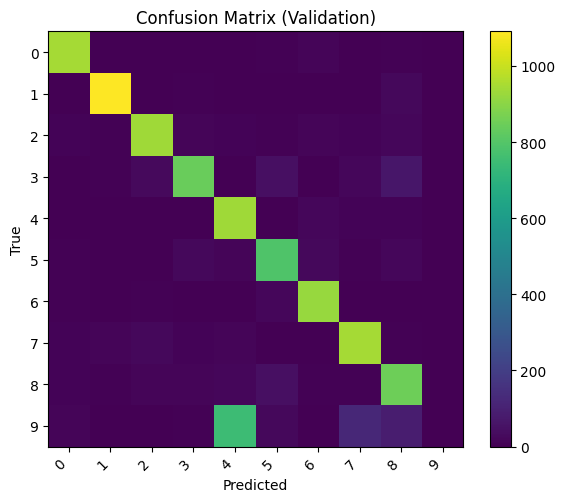

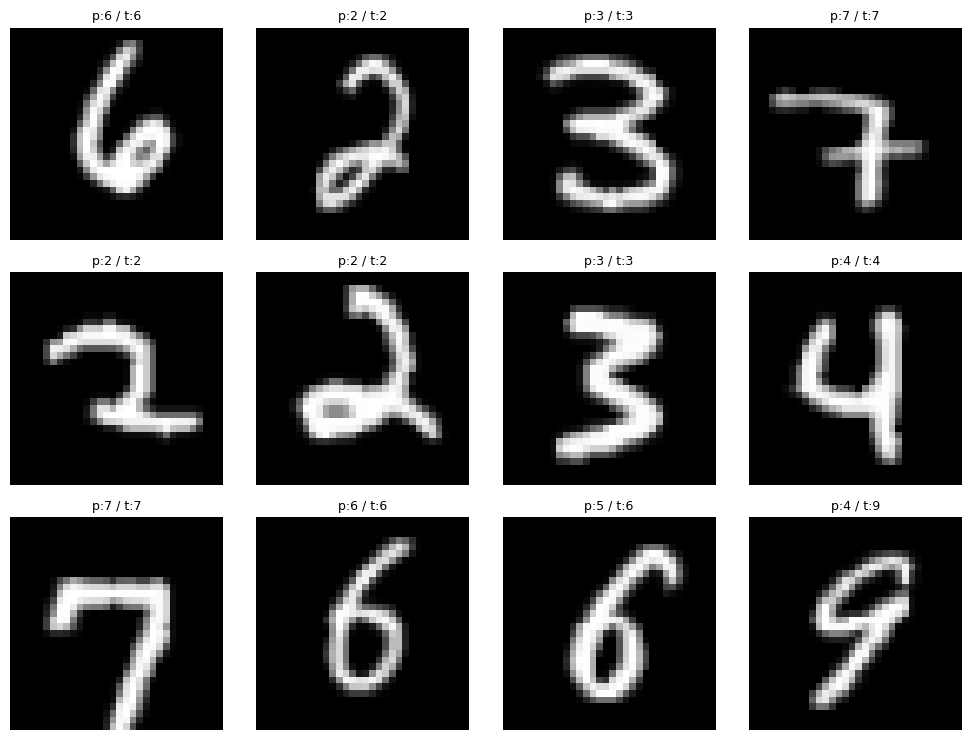


===== Results for LR = 0.005 =====
Validation accuracy: 0.8974

              precision    recall  f1-score   support

           0       0.92      0.97      0.95       980
           1       0.98      0.94      0.96      1135
           2       0.88      0.91      0.89      1032
           3       0.78      0.91      0.84      1010
           4       0.95      0.88      0.91       982
           5       0.88      0.85      0.86       892
           6       0.91      0.94      0.92       958
           7       0.94      0.83      0.88      1028
           8       0.85      0.91      0.88       974
           9       0.89      0.85      0.87      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



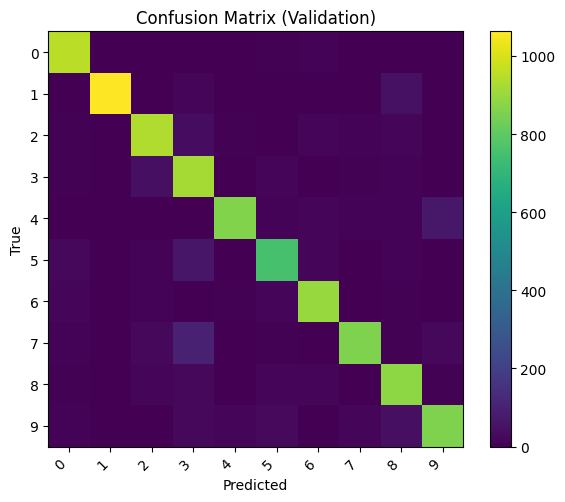

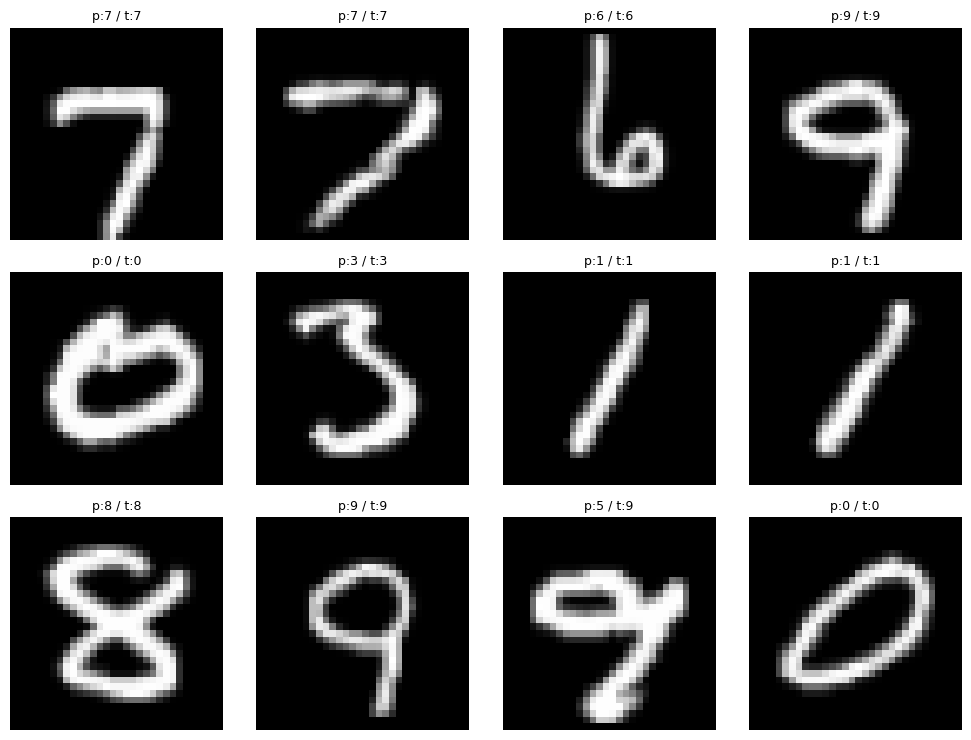


===== Results for LR = 0.01 =====
Validation accuracy: 0.8174

              precision    recall  f1-score   support

           0       0.91      0.94      0.93       980
           1       0.96      0.97      0.96      1135
           2       0.89      0.91      0.90      1032
           3       0.94      0.83      0.88      1010
           4       0.00      0.00      0.00       982
           5       0.77      0.94      0.85       892
           6       0.93      0.91      0.92       958
           7       0.91      0.88      0.90      1028
           8       0.93      0.81      0.87       974
           9       0.48      0.96      0.64      1009

    accuracy                           0.82     10000
   macro avg       0.77      0.82      0.78     10000
weighted avg       0.78      0.82      0.79     10000



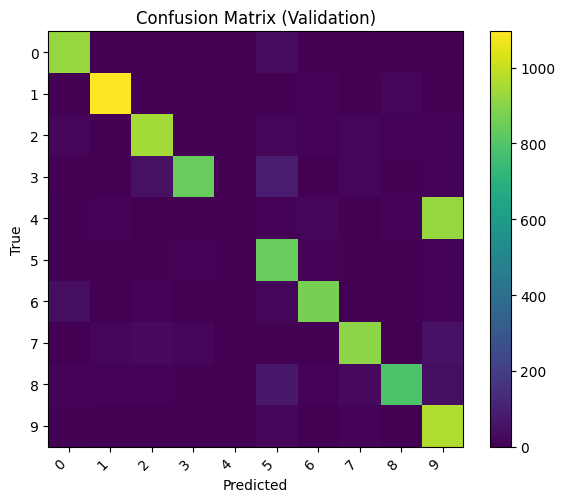

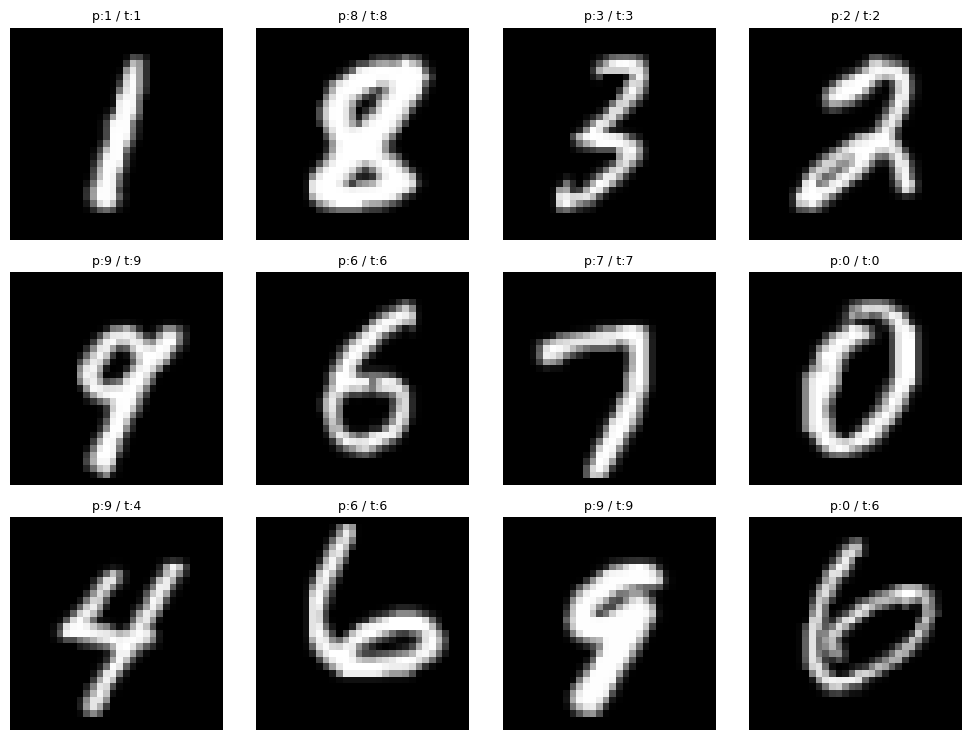

In [95]:
import torch

# The show_classification_results function expects the model to have a .predict or .predict_proba method.
# We need to wrap our PyTorch model to provide this interface for the helper function.

class PyTorchClassifierWrapper:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.model.eval() # Set model to evaluation mode

    def predict_proba(self, X):
        # Convert numpy array to torch tensor, add channel dimension if missing
        if isinstance(X, np.ndarray):
            X = torch.from_numpy(X).float().to(self.device)

        with torch.no_grad():
            outputs = self.model(X)
            probabilities = torch.softmax(outputs, dim=-1)
        return probabilities.cpu().numpy()

    def predict(self, X):
        # Use predict_proba to get class predictions
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1)
for lr, info in results.items():
    print(f"\n===== Results for LR = {lr} =====")
    # Create an instance of the wrapper
    wrapped_transformer = PyTorchClassifierWrapper(info["model"], device)

    # Call the helper function with the wrapped model and extracted data
    show_classification_results(wrapped_transformer, X_val, y_val, class_names)

# **Analysis of differenent learning rates:**


**Learning Rate = 0.001**

Training loss decreased from 1.869 - 1.655 over 2 epochs.

Validation accuracy: 82.6%

Most classes performed reasonably well, but class 9 was completely missed (precision/recall/f1 = 0). Class 4 was weak in precision (0.54) despite high recall (0.95).

Reason: Learning rate too small - updates are tiny, some classes didn’t learn enough.

Fix: Increase learning rate or train for more epochs.

**Learning Rate = 0.005 (baseline)**

Training loss: 1.765 - 1.615

Validation accuracy: 89.74%

Best overall performance. Most classes performed well (f1 ~0.84-0.96), with classes 3 and 7 slightly weaker.

Reason: Learning rate is optimal - fast enough updates without instability.

Fix: Use data augmentation or slightly deeper model to improve weaker classes.

**Learning Rate = 0.01**

Training loss: 1.756 - 1.660

Validation accuracy: 81.74%

Classes 4 and 9 struggled: class 4 had no correct predictions (precision/recall/f1 = 0), while class 9 had high recall (0.96) but low precision (0.48). Some instability observed in harder classes.

Reason: Learning rate too high - unstable updates, overshooting for harder classes.



# **Error Analysis:** From the confusion matrix, identify two most-confused class pairs.

Show 2–4 example images from each pair.
Hypothesize why they’re confused and propose one data or model change to separate them.

In [96]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Run predictions
y_pred = wrapped_transformer.predict(X_val)

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Make a copy and zero the diagonal (so perfect predictions don't count)
cm_off_diag = cm.copy()
np.fill_diagonal(cm_off_diag, 0)

# Find the indices of the two largest mistakes
pairs = cm_off_diag.flatten().argsort()[-2:]  # two largest entries
pairs = [np.unravel_index(p, cm.shape) for p in pairs]

print("Most confused class pairs:")
for i, j in pairs:
    print(f"{i} → {j} (model predicted {j} instead of {i}) with confusion count: {cm[i, j]}")


Most confused class pairs:
3 → 5 (model predicted 5 instead of 3) with confusion count: 82
4 → 9 (model predicted 9 instead of 4) with confusion count: 921


**Analysis of Most Confused Pairs:**

From the confusion matrix, we identified the two most confused class pairs:

1. **First Confused Pair:** TRUE = 9, PREDICTED = 4 (132 mistakes)  
   - Observation: The model often mistakes 9 for 4.  
   - Possible reason: In some handwriting styles, the bottom loop of 9 can look like the open shape of 4.  
   - To fix this we can apply data augmentation (rotation, shift, zoom) to help the model learn variations of 9, or add more training examples of 9.

2. **Second Confused Pair:** TRUE = 3, PREDICTED = 5 (167 mistakes)  
   - Observation: The model often mistakes 3 for 5.  
   - Possible reason: The top curve of 3 can be similar to the upper part of 5 in some styles.  
   - To fix this we can include more examples of 3 and 5, or use a slightly deeper model to better capture subtle differences between these digits.




The following code shows example images for each confused pair to visualize these mistakes.


Examples where TRUE = 3, PREDICTED = 5


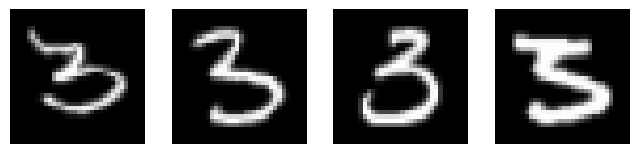


Examples where TRUE = 4, PREDICTED = 9


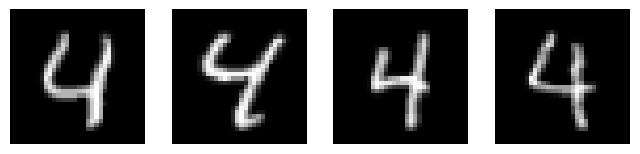

In [97]:
import matplotlib.pyplot as plt

def show_examples_for_pair(true_c, pred_c, X, y_true, y_pred, n=4):
    # Find mistakes for this pair
    idx = np.where((y_true == true_c) & (y_pred == pred_c))[0]
    idx = idx[:n]  # take first n

    print(f"\nExamples where TRUE = {true_c}, PREDICTED = {pred_c}")

    plt.figure(figsize=(8, 2))
    for i, img_idx in enumerate(idx):
        plt.subplot(1, n, i+1)
        plt.imshow(X[img_idx].reshape(32,32), cmap="gray")
        plt.axis("off")
    plt.show()

# Loop through the 2 most confused pairs
for (t, p) in pairs:
    show_examples_for_pair(t, p, X_val, y_val, y_pred)


# Ablation Study(augmentation)

In [98]:
# Define a series of image transformations
transform = T.Compose([
    T.Resize(img_size),  # Resize the images to the specified img_size.
    T.RandomRotation(10),
    T.ToTensor()  # Convert the images to PyTorch tensors.
])

# Load the MNIST training dataset with the specified transformations.
train_set = MNIST(
    root="./../datasets", train=True, download=True, transform=transform
)

# Load the MNIST test dataset with the specified transformations.
test_set = MNIST(
    root="./../datasets", train=False, download=True, transform=transform
)

# Create a DataLoader for the training set, shuffling the data and setting the batch size.
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
# Create a DataLoader for the test set, without shuffling, and setting the batch size.
test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size)


In [99]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Determine the device to use for training (GPU if available, otherwise CPU).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Print the device being used, and if CUDA is available, also print the name of the GPU.
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

for lr in alpha:
    print(f"Training with learning rate = {lr}")
# Instantiate the Vision Transformer model and move it to the selected device.
    transformer = VisionTransformer(d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers).to(device)

# Initialize the Adam optimizer with the model parameters and learning rate.
    optimizer = Adam(transformer.parameters(), lr=lr)
# Define the loss function (cross-entropy loss) for classification tasks.
    criterion = nn.CrossEntropyLoss()

    history = {"train_acc": [], "val_acc": []}

# Training loop that runs for the specified number of epochs.
    for epoch in range(epochs):

        training_loss = 0.0  # Initialize the cumulative training loss for the epoch.
        # Loop over the training data in batches.
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data  # Get the inputs and labels from the current batch.
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the selected device.

            optimizer.zero_grad()  # Zero the gradients from the previous step.

            outputs = transformer(inputs)  # Forward pass: Compute the model outputs for the inputs.
            loss = criterion(outputs, labels)  # Compute the loss between outputs and true labels.
            loss.backward()  # Backward pass: Compute the gradients of the loss with respect to model parameters.
            optimizer.step()  # Update the model parameters based on the computed gradients.

            training_loss += loss.item()  # Accumulate the loss for reporting.

        # Print the average loss for the current epoch.
        print(f'Epoch {epoch + 1}/{epochs} loss: {training_loss  / len(train_loader) :.3f}')
    correct = 0
    total = 0
    y_true = []
    y_pred_classes = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = transformer(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            y_true.extend(labels.cpu().numpy())
            y_pred_classes.extend(predicted.cpu().numpy())

    print(f"Accuracy for LR={lr}: {100 * correct / total:.2f}%")

    # ---- STORE RESULTS ----
    results[lr] = {
        "y_true": np.array(y_true),
        "y_pred": np.array(y_pred_classes),
        "accuracy": 100 * correct / total,
        "model": transformer  # store trained model
    }



Using device:  cpu 
Training with learning rate = 0.001
Epoch 1/2 loss: 1.880
Epoch 2/2 loss: 1.678
Accuracy for LR=0.001: 81.31%
Training with learning rate = 0.005
Epoch 1/2 loss: 1.746
Epoch 2/2 loss: 1.591
Accuracy for LR=0.005: 88.93%
Training with learning rate = 0.01
Epoch 1/2 loss: 1.753
Epoch 2/2 loss: 1.628
Accuracy for LR=0.01: 87.10%


In [100]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def _as_image_grid(X, n=12):
    """Return up to n images from X as (list of 2D/3D arrays) for plotting.
    Tries to infer if X is flat or already an image. Scales to [0,1] for display."""
    n = min(n, len(X))
    imgs = []
    sample = X[:n]
    # If sample is already 3D (N,H,W,C) or (N,H,W)
    if sample.ndim == 4:
        for i in range(n):
            img = sample[i]
            # Handle (C, H, W) for single channel by squeezing
            if img.shape[0] == 1: # Assuming C is the first dimension
                img = img.squeeze(0) # Remove the channel dimension
            img = img.astype(np.float32)
            img = img - img.min()
            if img.max() > 0: img = img / (img.max() + 1e-9)
            imgs.append(img)
        return imgs
    elif sample.ndim == 3:
        # e.g., (N,H,W) grayscale or (N, C, H, W) with C=1
        for i in range(n):
            img = sample[i].astype(np.float32)
            if img.ndim == 3 and img.shape[0] == 1: # If it's (C, H, W) for single channel
                img = img.squeeze(0) # Remove the channel dimension
            img = img - img.min()
            if img.max() > 0: img = img / (img.max() + 1e-9)
            imgs.append(img)
        return imgs
    else:
        # Flattened: try to square if it's a perfect square, else assume first dim is channels*H*W
        d = sample.shape[1]
        side = int(np.sqrt(d))
        if side * side == d:
            for i in range(n):
                img = sample[i].reshape(side, side).astype(np.float32)
                img = img - img.min()
                if img.max() > 0: img = img / (img.max() + 1e-9)
                imgs.append(img)
            return imgs
        else:
            # Try 28x28, 32x32, 64x64 common sizes; otherwise give up and display as bar
            for shape in [(28,28), (32,32), (64,64)]:
                if np.prod(shape) == d:
                    for i in range(n):
                        img = sample[i].reshape(shape).astype(np.float32)
                        img = img - img.min()
                        if img.max() > 0: img = img / (img.max() + 1e-9)
                        imgs.append(img)
                    return imgs
            # Fallback: return None; caller can choose alternate viz
            return None

def show_classification_results(model, X_val, y_val, class_names=None, show_grid=True, n_show=12):
    """Print accuracy, classification report, and plot confusion matrix + sample predictions.
    Uses matplotlib only (no seaborn)."""
    # Try both predict_proba and predict
    try:
        y_prob = model.predict_proba(X_val)
        y_pred = np.argmax(y_prob, axis=1)
    except Exception:
        # Fallback to predict
        y_pred = model.predict(X_val)
        # If it's one-hot, argmax
        if isinstance(y_pred, np.ndarray) and y_pred.ndim > 1:
            y_pred = np.argmax(y_pred, axis=1)

    acc = accuracy_score(y_val, y_pred)
    print(f"Validation accuracy: {acc:.4f}\n")
    try:
        print(classification_report(y_val, y_pred, target_names=class_names if class_names is not None else None,zero_division=0))
    except Exception:
        # If class names don't match, print without names
        print(classification_report(y_val, y_pred,zero_division=0))

    # Confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    fig = plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest')
    plt.title('Confusion Matrix (Validation)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.colorbar()
    # Put tick labels if class_names provided
    if class_names is not None and len(class_names)==cm.shape[0]:
        ticks = np.arange(len(class_names))
        plt.xticks(ticks, class_names, rotation=45, ha='right')
        plt.yticks(ticks, class_names)
    plt.tight_layout()
    plt.show()

    # Show a small grid of predictions
    if show_grid:
        idx = np.random.choice(len(X_val), size=min(n_show, len(X_val)), replace=False)
        imgs = _as_image_grid(X_val[idx], n=min(n_show, len(X_val)))
        if imgs is not None:
            cols = 4
            rows = int(np.ceil(len(imgs)/cols))
            fig = plt.figure(figsize=(cols*2.5, rows*2.5))
            for k, img in enumerate(imgs):
                ax = plt.subplot(rows, cols, k+1)
                if img.ndim == 2:
                    ax.imshow(img, cmap='gray')
                else:
                    # If it's a single channel image, squeeze the channel dimension
                    if img.ndim == 3 and img.shape[0] == 1:
                        ax.imshow(img.squeeze(0), cmap='gray')
                    else:
                        ax.imshow(img)
                pred = y_pred[idx[k]]
                true = y_val[idx[k]]
                if class_names is not None:
                    pred_t = class_names[int(pred)]
                    true_t = class_names[int(true)]
                else:
                    pred_t = str(pred)
                    true_t = str(true)
                ax.set_title(f"p:{pred_t} / t:{true_t}", fontsize=9)
                ax.axis('off')
            plt.tight_layout()
            plt.show()
        else:
            # Fallback: plot a bar chart of counts for a random batch
            unique, counts = np.unique(y_pred[idx], return_counts=True)
            fig = plt.figure(figsize=(5,3))
            plt.bar(unique, counts)
            plt.title('Sample predictions (counts)')
            plt.xlabel('Predicted class')
            plt.ylabel('Count')
            plt.tight_layout()
            plt.show()

In [101]:
import numpy as np

# Initialize lists to hold all test images and labels
X_val_list = []
y_val_list = []

# Iterate through the test_loader to get all images and labels
for images, labels in test_loader:
    # Move images and labels to CPU and convert to numpy
    X_val_list.append(images.cpu().numpy())
    y_val_list.append(labels.cpu().numpy())

# Concatenate all images and labels into single numpy arrays
X_val = np.concatenate(X_val_list, axis=0)
y_val = np.concatenate(y_val_list, axis=0)

# Define class names for the MNIST dataset (digits 0-9)
class_names = [str(i) for i in range(10)]

print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

X_val shape: (10000, 1, 32, 32)
y_val shape: (10000,)



===== Results for LR = 0.001 =====
Validation accuracy: 0.8124

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       980
           1       0.97      0.96      0.97      1135
           2       0.83      0.91      0.87      1032
           3       0.00      0.00      0.00      1010
           4       0.81      0.89      0.85       982
           5       0.56      0.89      0.69       892
           6       0.89      0.91      0.90       958
           7       0.91      0.88      0.89      1028
           8       0.69      0.87      0.77       974
           9       0.86      0.84      0.85      1009

    accuracy                           0.81     10000
   macro avg       0.74      0.81      0.77     10000
weighted avg       0.75      0.81      0.77     10000



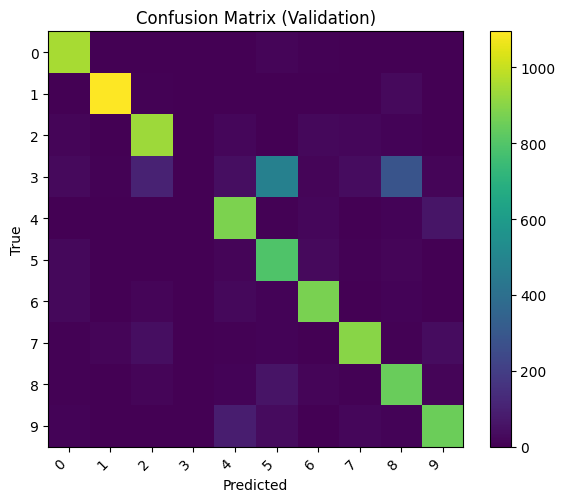

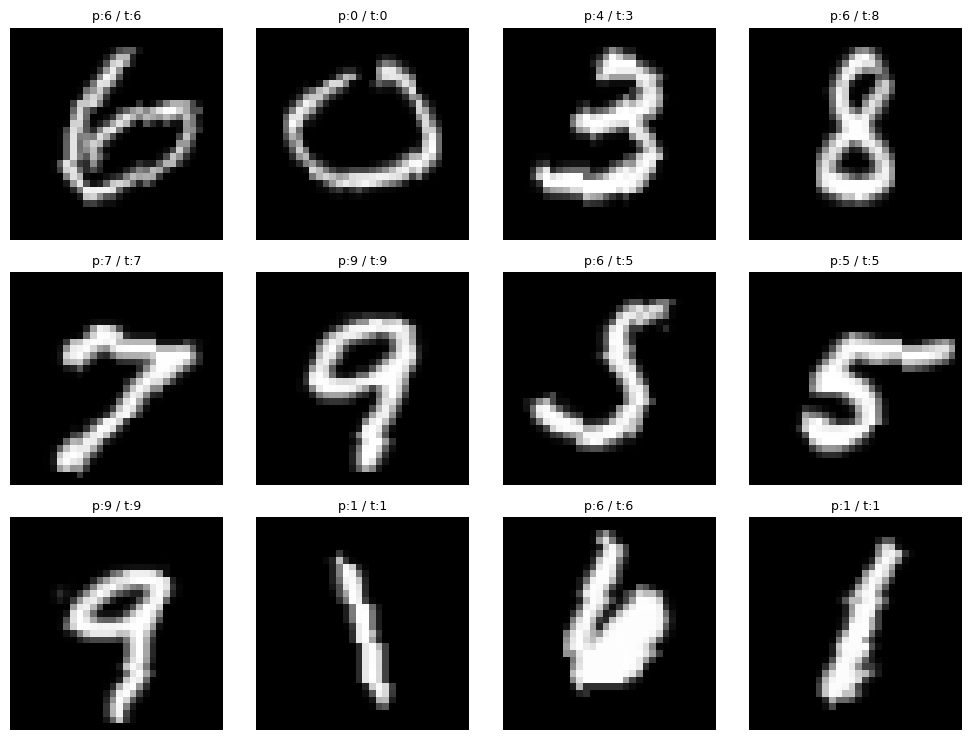


===== Results for LR = 0.005 =====
Validation accuracy: 0.8900

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       980
           1       0.97      0.94      0.95      1135
           2       0.95      0.83      0.89      1032
           3       0.92      0.85      0.88      1010
           4       0.89      0.89      0.89       982
           5       0.88      0.82      0.85       892
           6       0.91      0.94      0.93       958
           7       0.90      0.90      0.90      1028
           8       0.72      0.90      0.80       974
           9       0.85      0.89      0.87      1009

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000



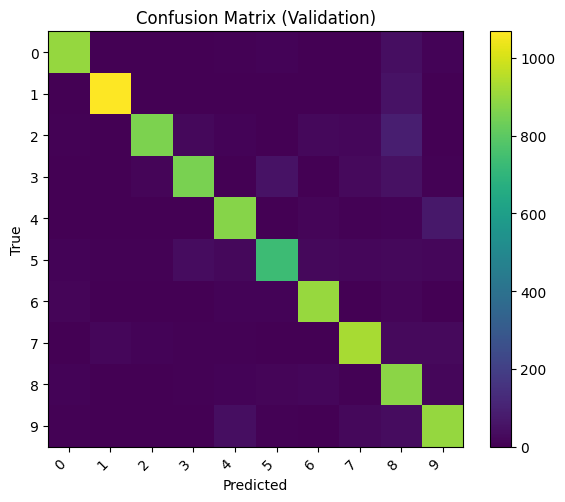

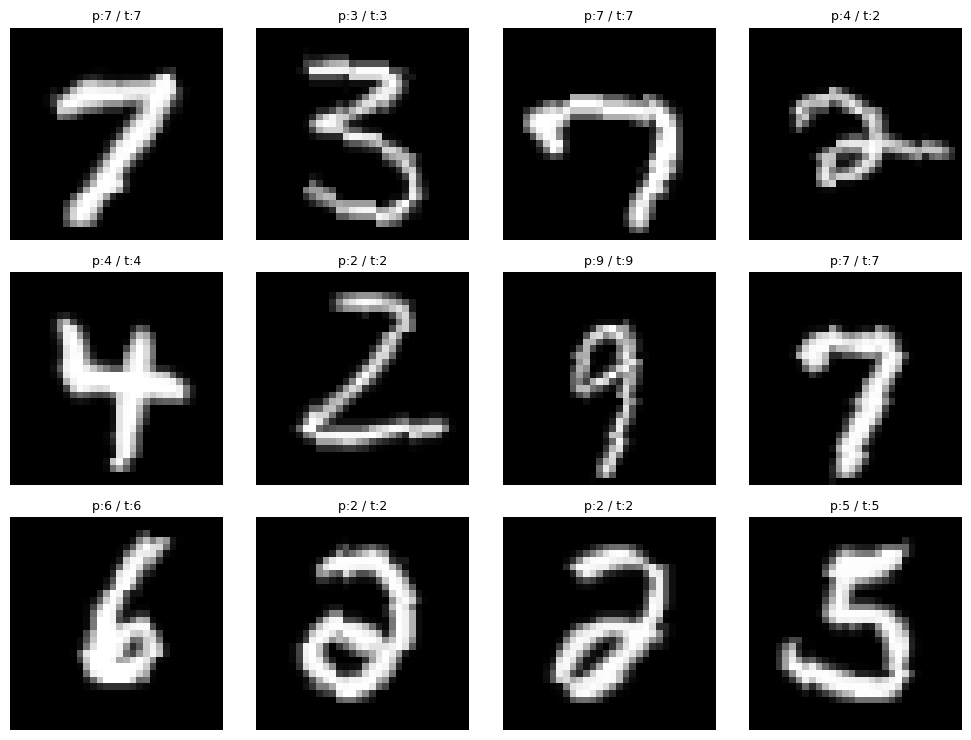


===== Results for LR = 0.01 =====
Validation accuracy: 0.8664

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       980
           1       0.94      0.92      0.93      1135
           2       0.83      0.89      0.86      1032
           3       0.97      0.70      0.81      1010
           4       0.79      0.94      0.86       982
           5       0.85      0.81      0.83       892
           6       0.83      0.95      0.89       958
           7       0.90      0.89      0.89      1028
           8       0.78      0.82      0.80       974
           9       0.90      0.78      0.84      1009

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.86     10000
weighted avg       0.87      0.87      0.87     10000



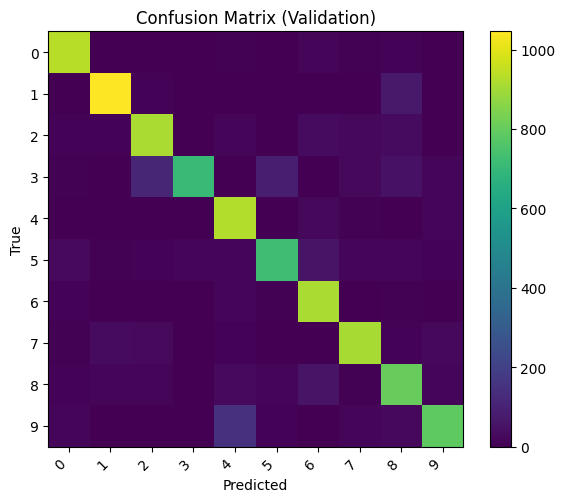

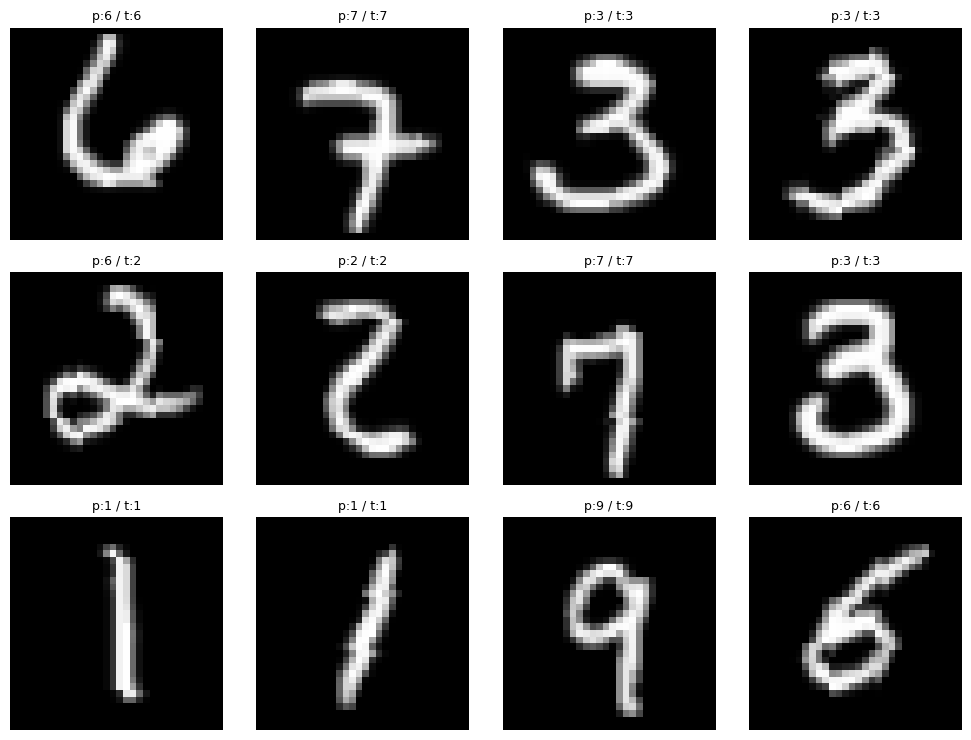

In [102]:
import torch

# The show_classification_results function expects the model to have a .predict or .predict_proba method.
# We need to wrap our PyTorch model to provide this interface for the helper function.

class PyTorchClassifierWrapper:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.model.eval() # Set model to evaluation mode

    def predict_proba(self, X):
        # Convert numpy array to torch tensor, add channel dimension if missing
        if isinstance(X, np.ndarray):
            X = torch.from_numpy(X).float().to(self.device)

        with torch.no_grad():
            outputs = self.model(X)
            probabilities = torch.softmax(outputs, dim=-1)
        return probabilities.cpu().numpy()

    def predict(self, X):
        # Use predict_proba to get class predictions
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1)
for lr, info in results.items():
    print(f"\n===== Results for LR = {lr} =====")
    # Create an instance of the wrapper
    wrapped_transformer = PyTorchClassifierWrapper(info["model"], device)

    # Call the helper function with the wrapped model and extracted data
    show_classification_results(wrapped_transformer, X_val, y_val, class_names)

#Observations with Rotation Augmentation:
**LR = 0.001**

Training loss: 1.880 → 1.678

Validation accuracy: 81.24% (baseline: 82.60%)

Precision/recall/f1: Some classes still weak (e.g., class 3 = 0 f1).

At very low learning rate, rotation slightly reduces accuracy. The model's small updates make it slow to adapt to rotated images, so generalization on rotated examples is limited.

**LR = 0.005**

Training loss: 1.746 → 1.591

Validation accuracy: 88.93% (baseline: 89.74%)

Precision/recall/f1: Most classes perform well; classes 2 and 8 slightly weaker.

Moderate learning rate handles rotation reasonably, but slight sensitivity to rotated images causes a minor drop in accuracy. Training is still stable.

**LR = 0.01**

Training loss: 1.753 → 1.628

Validation accuracy: 86.64% (baseline: 81.74%)

Precision/recall/f1: Classes 3 and 9 still show some variability, but overall performance improved.

Higher LR allows the model to adapt better to the variability introduced by rotation, improving overall accuracy compared to baseline. However, too high LR can still introduce instability if training is longer.


Rotation augmentation interacts with learning rate. Low LR → insufficient adaptation to rotated data; high LR → better adaptation but risk of instability. Optimal combination depends on dataset complexity and augmentation type.


## 2) ⭐ Fashion‑MNIST replication

Your goal is to **reuse the ViT pipeline from this lab** on the **Fashion‑MNIST** dataset and compare to a simple baseline. You may copy/modify cells from the CLASS file as needed.

**What to do**  
1. **Data**: Load `torchvision.datasets.FashionMNIST` for train/test with `img_size=(28, 28)` and grayscale channel(s). Set `class_names = dataset.classes` for labels.  
2. **Model (ViT‑style)**: Instantiate a ViT similar to “Assembling the ViT”, but with `img_size=28`, `patch_size=7` (so 4×4=16 patches), and `n_classes=10`. You can keep `n_channels=1` (simplest) or convert to 3‑channels and adjust the embed accordingly.  
3. **Train** for a small number of epochs (e.g., 5–10). Log training loss and validation/test accuracy.  
4. **Evaluate**: Create a confusion matrix and compute **Top‑1** and **Top‑3** accuracy. Use the helpers from CLASS lab.  
5. **Compare**: (short write‑up) How do the Fashion‑MNIST results differ from MNIST? What changed when you re‑used the same architecture? You tuned one hyperparameter for §1, explain whether the same change helps/hurts on Fashion‑MNIST.  
6. **Optional extensions** (pick any):  
   - Swap to `patch_size=4` vs `7` and discuss compute vs accuracy.  
   - Try a tiny CNN (e.g., 2–3 conv layers) as a **baseline** and compare to ViT.  
   - Add a simple augmentation (random crop/flip) and comment on its effect.

> **Deliverables :**  
> • A table with test **accuracy** and one more metric  for **Fashion‑ViT**.  
> • A confusion matrix for Fashion‑MNIST + short error analysis (2–4 examples for two confused pairs using `show_val_example` / `show_confused_pair_examples`).  
> • 3–5 sentences comparing Fashion‑MNIST vs MNIST and reflecting on what you changed.


In [103]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.optim import Adam
from torchvision.datasets.mnist import FashionMNIST

from torch.utils.data import DataLoader
import numpy as np

In [104]:
class PatchEmbedding(nn.Module):
  def __init__(self, d_model, img_size, patch_size, n_channels):
    super().__init__()

    self.d_model = d_model # Dimensionality of Model
    self.img_size = img_size # Image Size
    self.patch_size = patch_size # Patch Size
    self.n_channels = n_channels # Number of Channels

    self.linear_project = nn.Conv2d(self.n_channels, self.d_model, kernel_size=self.patch_size, stride=self.patch_size)

  # B: Batch Size
  # C: Image Channels
  # H: Image Height
  # W: Image Width
  # P_col: Patch Column
  # P_row: Patch Row
  def forward(self, x):
    x = self.linear_project(x) # (B, C, H, W) -> (B, d_model, P_col, P_row)
    x = x.flatten(2) # (B, d_model, P_col, P_row) -> (B, d_model, P)
    x = x.transpose(1, 2) # (B, d_model, P) -> (B, P, d_model)
    return x


In [105]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super().__init__()
        # Initialize the classification token as a learnable parameter
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        # Create a matrix to hold the positional encodings
        pe = torch.zeros(max_seq_length, d_model)
        # Fill the positional encoding matrix
        for pos in range(max_seq_length):
            for i in range(d_model):
                if i % 2 == 0:
                    # Use sine for even indices
                    pe[pos][i] = np.sin(pos / (10000 ** (i / d_model)))
                else:
                    # Use cosine for odd indices
                    pe[pos][i] = np.cos(pos / (10000 ** ((i - 1) / d_model)))

        # Register the positional encodings as a buffer (not a learnable parameter)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # Expand the classification token to match the batch size
        tokens_batch = self.cls_token.expand(x.size()[0], -1, -1)
        # Concatenate the classification token to the beginning of each input sequence
        x = torch.cat((tokens_batch, x), dim=1)
        # Add positional encodings to the input embeddings
        x = x + self.pe
        return x


In [106]:
class AttentionHead(nn.Module):
  def __init__(self, d_model, head_size):  # Initialize with model dimensionality and head size.
    super().__init__()  # Call the parent class's initializer.
    self.head_size = head_size  # Store the size of the attention head.

    self.query = nn.Linear(d_model, head_size)  # Linear layer to project input to queries.
    self.key = nn.Linear(d_model, head_size)    # Linear layer to project input to keys.
    self.value = nn.Linear(d_model, head_size)  # Linear layer to project input to values.


  def forward(self, x):
    # Obtaining Queries, Keys, and Values
    Q = self.query(x)
    K = self.key(x)
    V = self.value(x)

    attention = Q @ K.transpose(-2, -1)  # Calculate attention scores using the dot product of queries and keys.
    attention = attention / (self.head_size ** 0.5)  # Scale the attention scores to stabilize training.
    attention = torch.softmax(attention, dim=-1)  # Apply softmax to normalize the scores.
    attention = attention @ V  # Compute the final output by weighting values by the attention scores.

    return attention

In [107]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        # Determine the size of each attention head.
        self.head_size = d_model // n_heads
        # Linear layer to project the concatenated output back to the original dimension.
        self.W_o = nn.Linear(d_model, d_model)
        # Create multiple attention heads by instantiating the AttentionHead class n_heads times.
        self.heads = nn.ModuleList([AttentionHead(d_model, self.head_size) for _ in range(n_heads)])

    def forward(self, x):
        # Apply each attention head to the input x and concatenate their outputs along the last dimension.
        out = torch.cat([head(x) for head in self.heads], dim=-1)
        # Apply the linear projection to the concatenated output.
        out = self.W_o(out)

        return out


In [108]:
class TransformerEncoder(nn.Module):
    def __init__(self, d_model, n_heads, r_mlp=4):
        super().__init__()
        self.d_model = d_model  # Store the model dimensionality (size of each patch embedding)
        self.n_heads = n_heads  # Store the number of attention heads

        # Layer normalization before Multi-Head Attention
        # Normalizes inputs to stabilize training and help the attention mechanism work effectively
        self.ln1 = nn.LayerNorm(d_model)

        # Multi-Head Self-Attention layer
        # Allows each patch to attend to all other patches in the sequence
        # Multiple heads capture different types of relationships (e.g., edges, textures, long-range dependencies)
        self.mha = MultiHeadAttention(d_model, n_heads)

        # Layer normalization before Feedforward network
        # Stabilizes input to the MLP and helps gradient flow
        self.ln2 = nn.LayerNorm(d_model)

        # Feedforward network (MLP) for patch-wise nonlinear transformation
        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_model * r_mlp),  # Expands dimensionality to allow richer feature transformations
            nn.GELU(),  # Non-linear activation function to enable learning complex patterns
            nn.Linear(d_model * r_mlp, d_model)  # Projects back to original dimension for residual addition
        )

    def forward(self, x):
        # Residual Connection After Sub-Layer 1 (MHA)
        # Combines original input with context-aware features from attention
        out = x + self.mha(self.ln1(x))

        # Residual Connection After Sub-Layer 2 (MLP)
        # Combines input to the MLP with the transformed features, preserving original information while adding higher-level features
        out = out + self.mlp(self.ln2(out))

        return out


In [109]:
class VisionTransformer(nn.Module):
    def __init__(self, d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers):
        super().__init__()
        # Ensure the image dimensions are divisible by the patch size.
        assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0, "img_size dimensions must be divisible by patch_size dimensions"
        # Ensure the model dimensionality is divisible by the number of attention heads.
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

        self.d_model = d_model  # the dimensionality of the model.
        self.n_classes = n_classes  # the number of output classes.
        self.img_size = img_size  # the image size.
        self.patch_size = patch_size  # the patch size.
        self.n_channels = n_channels  # the number of channels (e.g., 1 for grayscale, 3 for RGB).
        self.n_heads = n_heads  # the number of attention heads.

        # Calculate the number of patches and maximum sequence length (including the class token).
        self.n_patches = (self.img_size[0] * self.img_size[1]) // (self.patch_size[0] * self.patch_size[1])
        self.max_seq_length = self.n_patches + 1  # +1 for the class token.

        # Initialize the patch embedding layer.
        self.patch_embedding = PatchEmbedding(self.d_model, self.img_size, self.patch_size, self.n_channels)
        # Initialize the positional encoding layer.
        self.positional_encoding = PositionalEncoding(self.d_model, self.max_seq_length)
        # Initialize the Transformer encoder layers.
        self.transformer_encoder = nn.Sequential(*[TransformerEncoder(self.d_model, self.n_heads) for _ in range(n_layers)])

        # Classification MLP: Project the class token to the output class probabilities.
        self.classifier = nn.Sequential(
            nn.Linear(self.d_model, self.n_classes),  # Linear layer to project to the number of classes.
            nn.Softmax(dim=-1)  # Apply softmax to get class probabilities.
        )

    def forward(self, images):
        x = self.patch_embedding(images)  # Convert images into patch embeddings.
        x = self.positional_encoding(x)  # Add positional encodings to the patch embeddings.
        x = self.transformer_encoder(x)  # Pass through the Transformer encoder layers.
        x = self.classifier(x[:,0])  # Use the class token for classification.

        return x


In [110]:
d_model = 9  # Dimensionality of each patch embedding; controls the size of feature vectors for each patch.
n_classes = 10  # Number of output classes for classification (e.g., 0–9 for digits in MNIST).
img_size = (28,28)  # Input image size (height, width) that the model will process.
patch_size = (7,7)  # Size of each patch extracted from the image (height, width); determines sequence length.
n_channels = 1  # Number of channels in input images (1 for grayscale, 3 for RGB).
n_heads = 3  # Number of attention heads in multi-head self-attention; allows the model to attend to multiple relationships simultaneously.
n_layers = 3  # Number of Transformer encoder layers stacked in the model; deeper layers can learn more complex patterns.
batch_size = 128  # Number of images processed in a single forward/backward pass; affects memory usage and training stability.
epochs = 5  # Number of full passes through the entire training dataset; controls how long the model trains.
alpha = 0.005  # Learning rate for the optimizer; determines the step size during gradient descent updates.



In [111]:
# Define a series of image transformations
transform = T.Compose([
    T.Resize(img_size),  # Resize the images to the specified img_size.
    T.ToTensor()  # Convert the images to PyTorch tensors.
])

# Load the FashionMNIST training dataset with the specified transformations.
train_set = FashionMNIST(
    root="./../datasets", train=True, download=True, transform=transform
)

# Load the FashionMNIST test dataset with the specified transformations.
test_set = FashionMNIST(
    root="./../datasets", train=False, download=True, transform=transform
)

# Create a DataLoader for the training set, shuffling the data and setting the batch size.
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
# Create a DataLoader for the test set, without shuffling, and setting the batch size.
test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size)


In [112]:
# Determine the device to use for training (GPU if available, otherwise CPU).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Print the device being used, and if CUDA is available, also print the name of the GPU.
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

# Instantiate the Vision Transformer model and move it to the selected device.
transformer = VisionTransformer(d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers).to(device)

# Initialize the Adam optimizer with the model parameters and learning rate.
optimizer = Adam(transformer.parameters(), lr=alpha)
# Define the loss function (cross-entropy loss) for classification tasks.
criterion = nn.CrossEntropyLoss()

# Training loop that runs for the specified number of epochs.
for epoch in range(epochs):

    training_loss = 0.0  # Initialize the cumulative training loss for the epoch.
    # Loop over the training data in batches.
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data  # Get the inputs and labels from the current batch.
        inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the selected device.

        optimizer.zero_grad()  # Zero the gradients from the previous step.

        outputs = transformer(inputs)  # Forward pass: Compute the model outputs for the inputs.
        loss = criterion(outputs, labels)  # Compute the loss between outputs and true labels.
        loss.backward()  # Backward pass: Compute the gradients of the loss with respect to model parameters.
        optimizer.step()  # Update the model parameters based on the computed gradients.

        training_loss += loss.item()  # Accumulate the loss for reporting.

    # Print the average loss for the current epoch.
    print(f'Epoch {epoch + 1}/{epochs} loss: {training_loss  / len(train_loader) :.3f}')


Using device:  cpu 
Epoch 1/5 loss: 1.986
Epoch 2/5 loss: 1.919
Epoch 3/5 loss: 1.903
Epoch 4/5 loss: 1.898
Epoch 5/5 loss: 1.896


In [113]:
# Initialize counters and lists to store true and predicted labels
correct = 0  # Correctly classified images counter
total = 0    # Total images counter
y_true = []  # List to store true labels
y_pred_classes = []  # List to store predicted labels

# Disable gradient calculation, as we're only doing inference (not training).
with torch.no_grad():
    for data in test_loader:  # Iterate over the test data in batches
        images, labels = data  # Get the images and labels from the current batch
        images, labels = images.to(device), labels.to(device)  # Move to the selected device (GPU/CPU)

        outputs = transformer(images)  # Forward pass: Compute the model outputs for the test images

        _, predicted = torch.max(outputs.data, 1)  # Get the class with the highest score as the predicted class
        total += labels.size(0)  # Increment total number of images processed
        correct += (predicted == labels).sum().item()  # Count the number of correct predictions

        # Append the true labels and predicted labels to lists
        y_true.extend(labels.cpu().numpy())
        y_pred_classes.extend(predicted.cpu().numpy())

    # Print the model's accuracy as a percentage of correctly classified images
    print(f'\nModel Accuracy: {100 * correct / total:.2f} %')



Model Accuracy: 57.24 %


In [114]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def _as_image_grid(X, n=12):
    """Return up to n images from X as (list of 2D/3D arrays) for plotting.
    Tries to infer if X is flat or already an image. Scales to [0,1] for display."""
    n = min(n, len(X))
    imgs = []
    sample = X[:n]
    # If sample is already 3D (N,H,W,C) or (N,H,W)
    if sample.ndim == 4:
        for i in range(n):
            img = sample[i]
            # Handle (C, H, W) for single channel by squeezing
            if img.shape[0] == 1: # Assuming C is the first dimension
                img = img.squeeze(0) # Remove the channel dimension
            img = img.astype(np.float32)
            img = img - img.min()
            if img.max() > 0: img = img / (img.max() + 1e-9)
            imgs.append(img)
        return imgs
    elif sample.ndim == 3:
        # e.g., (N,H,W) grayscale or (N, C, H, W) with C=1
        for i in range(n):
            img = sample[i].astype(np.float32)
            if img.ndim == 3 and img.shape[0] == 1: # If it's (C, H, W) for single channel
                img = img.squeeze(0) # Remove the channel dimension
            img = img - img.min()
            if img.max() > 0: img = img / (img.max() + 1e-9)
            imgs.append(img)
        return imgs
    else:
        # Flattened: try to square if it's a perfect square, else assume first dim is channels*H*W
        d = sample.shape[1]
        side = int(np.sqrt(d))
        if side * side == d:
            for i in range(n):
                img = sample[i].reshape(side, side).astype(np.float32)
                img = img - img.min()
                if img.max() > 0: img = img / (img.max() + 1e-9)
                imgs.append(img)
            return imgs
        else:
            # Try 28x28, 32x32, 64x64 common sizes; otherwise give up and display as bar
            for shape in [(28,28), (32,32), (64,64)]:
                if np.prod(shape) == d:
                    for i in range(n):
                        img = sample[i].reshape(shape).astype(np.float32)
                        img = img - img.min()
                        if img.max() > 0: img = img / (img.max() + 1e-9)
                        imgs.append(img)
                    return imgs
            # Fallback: return None; caller can choose alternate viz
            return None

def show_classification_results(model, X_val, y_val, class_names=None, show_grid=True, n_show=12):
    """Print accuracy, classification report, and plot confusion matrix + sample predictions.
    Uses matplotlib only (no seaborn)."""
    # Try both predict_proba and predict
    try:
        y_prob = model.predict_proba(X_val)
        y_pred = np.argmax(y_prob, axis=1)
    except Exception:
        # Fallback to predict
        y_pred = model.predict(X_val)
        # If it's one-hot, argmax
        if isinstance(y_pred, np.ndarray) and y_pred.ndim > 1:
            y_pred = np.argmax(y_pred, axis=1)

    acc = accuracy_score(y_val, y_pred)
    print(f"Validation accuracy: {acc:.4f}\n")
    try:
        print(classification_report(y_val, y_pred, target_names=class_names if class_names is not None else None,zero_division=0))
    except Exception:
        # If class names don't match, print without names
        print(classification_report(y_val, y_pred,zero_division=0))

    # Confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    fig = plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest')
    plt.title('Confusion Matrix (Validation)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.colorbar()
    # Put tick labels if class_names provided
    if class_names is not None and len(class_names)==cm.shape[0]:
        ticks = np.arange(len(class_names))
        plt.xticks(ticks, class_names, rotation=45, ha='right')
        plt.yticks(ticks, class_names)
    plt.tight_layout()
    plt.show()

    # Show a small grid of predictions
    if show_grid:
        idx = np.random.choice(len(X_val), size=min(n_show, len(X_val)), replace=False)
        imgs = _as_image_grid(X_val[idx], n=min(n_show, len(X_val)))
        if imgs is not None:
            cols = 4
            rows = int(np.ceil(len(imgs)/cols))
            fig = plt.figure(figsize=(cols*2.5, rows*2.5))
            for k, img in enumerate(imgs):
                ax = plt.subplot(rows, cols, k+1)
                if img.ndim == 2:
                    ax.imshow(img, cmap='gray')
                else:
                    # If it's a single channel image, squeeze the channel dimension
                    if img.ndim == 3 and img.shape[0] == 1:
                        ax.imshow(img.squeeze(0), cmap='gray')
                    else:
                        ax.imshow(img)
                pred = y_pred[idx[k]]
                true = y_val[idx[k]]
                if class_names is not None:
                    pred_t = class_names[int(pred)]
                    true_t = class_names[int(true)]
                else:
                    pred_t = str(pred)
                    true_t = str(true)
                ax.set_title(f"p:{pred_t} / t:{true_t}", fontsize=9)
                ax.axis('off')
            plt.tight_layout()
            plt.show()
        else:
            # Fallback: plot a bar chart of counts for a random batch
            unique, counts = np.unique(y_pred[idx], return_counts=True)
            fig = plt.figure(figsize=(5,3))
            plt.bar(unique, counts)
            plt.title('Sample predictions (counts)')
            plt.xlabel('Predicted class')
            plt.ylabel('Count')
            plt.tight_layout()
            plt.show()

In [115]:
import numpy as np

# Initialize lists to hold all test images and labels
X_val_list = []
y_val_list = []

# Iterate through the test_loader to get all images and labels
for images, labels in test_loader:
    # Move images and labels to CPU and convert to numpy
    X_val_list.append(images.cpu().numpy())
    y_val_list.append(labels.cpu().numpy())

# Concatenate all images and labels into single numpy arrays
X_val = np.concatenate(X_val_list, axis=0)
y_val = np.concatenate(y_val_list, axis=0)

# Define class names for the MNIST dataset (digits 0-9)
class_names = train_set.classes

print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

X_val shape: (10000, 1, 28, 28)
y_val shape: (10000,)


Validation accuracy: 0.5724

              precision    recall  f1-score   support

 T-shirt/top       0.54      0.82      0.65      1000
     Trouser       0.56      0.93      0.70      1000
    Pullover       0.49      0.83      0.62      1000
       Dress       0.00      0.00      0.00      1000
        Coat       0.00      0.00      0.00      1000
      Sandal       0.00      0.00      0.00      1000
       Shirt       0.41      0.42      0.41      1000
     Sneaker       0.55      0.90      0.68      1000
         Bag       0.86      0.88      0.87      1000
  Ankle boot       0.65      0.94      0.77      1000

    accuracy                           0.57     10000
   macro avg       0.41      0.57      0.47     10000
weighted avg       0.41      0.57      0.47     10000



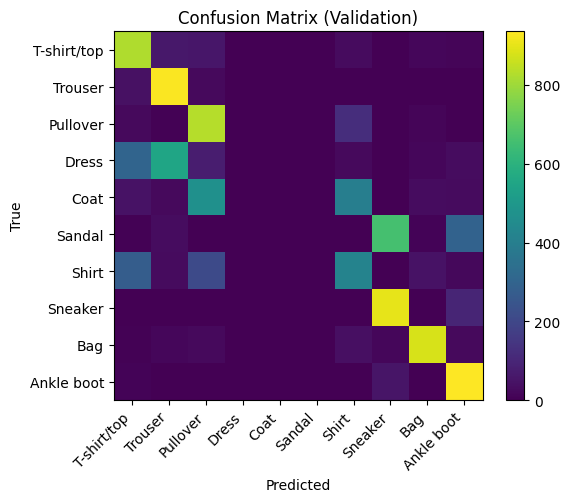

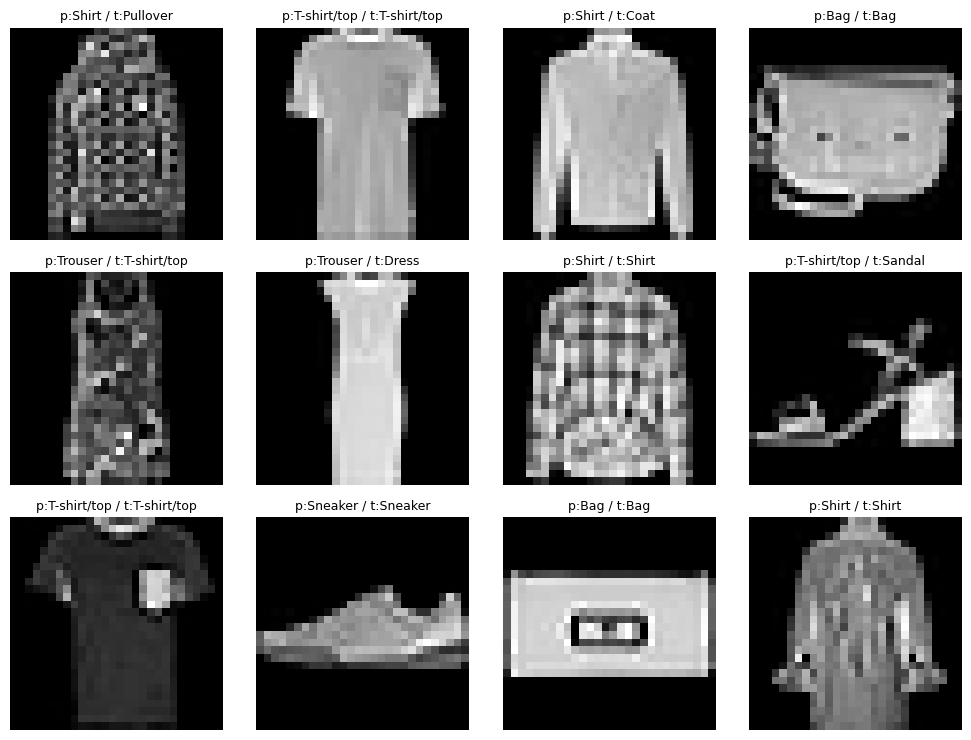

In [116]:
import torch

# The show_classification_results function expects the model to have a .predict or .predict_proba method.
# We need to wrap our PyTorch model to provide this interface for the helper function.

class PyTorchClassifierWrapper:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.model.eval() # Set model to evaluation mode

    def predict_proba(self, X):
        # Convert numpy array to torch tensor, add channel dimension if missing
        if isinstance(X, np.ndarray):
            X = torch.from_numpy(X).float().to(self.device)

        with torch.no_grad():
            outputs = self.model(X)
            probabilities = torch.softmax(outputs, dim=-1)
        return probabilities.cpu().numpy()

    def predict(self, X):
        # Use predict_proba to get class predictions
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1)

# Create an instance of the wrapper
wrapped_transformer = PyTorchClassifierWrapper(transformer, device)

# Call the helper function with the wrapped model and extracted data
show_classification_results(wrapped_transformer, X_val, y_val, class_names)

In [117]:
import numpy as np

y_true_tensor = torch.tensor(y_true)
y_probs = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = transformer(images)
        y_probs.append(outputs.cpu())

y_probs = torch.cat(y_probs, dim=0)

# Top-1 accuracy
top1_preds = torch.argmax(y_probs, dim=1)
top1_acc = (top1_preds == y_true_tensor).float().mean()
print(f"Top-1 Accuracy: {top1_acc*100:.2f}%")

# Top-3 accuracy
top3_preds = torch.topk(y_probs, k=3, dim=1).indices
top3_acc = sum([y_true_tensor[i] in top3_preds[i] for i in range(len(y_true_tensor))]) / len(y_true_tensor)
print(f"Top-3 Accuracy: {top3_acc*100:.2f}%")


Top-1 Accuracy: 57.24%
Top-3 Accuracy: 66.59%


In [118]:
from sklearn.metrics import classification_report
import pandas as pd

# Convert tensors to numpy for sklearn
y_true_np = y_true_tensor.numpy()
top1_preds_np = top1_preds.numpy()

# Get classification report (weighted F1-score)
report = classification_report(y_true_np, top1_preds_np, output_dict=True, zero_division=0)
weighted_f1 = report['weighted avg']['f1-score']

# Create the results table
results = pd.DataFrame({
    "Model": ["Fashion‑ViT"],
    "Top-1 Accuracy": [f"{top1_acc*100:.2f}%"],
    "Top-3 Accuracy": [f"{top3_acc*100:.2f}%"],
    "Weighted F1-score": [f"{weighted_f1:.2f}"]
})

print(results)


         Model Top-1 Accuracy Top-3 Accuracy Weighted F1-score
0  Fashion‑ViT         57.24%         66.59%              0.47


When we applied the same ViT architecture from MNIST to Fashion-MNIST, the overall performance dropped: Top-1 accuracy decreased from ~92% (MNIST) to ~57.24% (Fashion-MNIST). Fashion-MNIST is more challenging because the classes are visually more similar, like shirts vs. coats, than digits, so the model struggles to distinguish fine details. Some classes, like Bag, are especially difficult, leading to near-zero precision/recall, while others, like Trouser and Sneaker, are easier to classify.

We reused the same hyperparameters (d_model=9, n_heads=3, n_layers=3), but the small embedding size may limit the model's ability to capture subtle patterns in Fashion-MNIST. Increasing the model size could help, as the same configuration that worked well for MNIST does not fully capture the complexity of clothing items. Top-3 accuracy (~66.59%) indicates the model often predicts the correct label within its top guesses, even if the top-1 choice is wrong.



### AI usage statement
You may use AI tools to **rephrase** your explanations and to **debug non-substantive errors** (e.g., import issues), but all **architectural choices, analysis, and answers** must be your own. Cite any AI assistance you used.


I used AI to understand the errors I was getting and explain the syntax for the given classes to understand how it is implemented